# Individual Assignment
Done by Ashwin Philip George

## Data Exploration and Preparation

In [17]:
import pandas as pd

data = pd.read_csv('credit_card.csv')

In [18]:
data.isna().sum() #just to check if there are any NA or empty values

income     0
age        0
loan       0
default    0
dtype: int64

In [19]:
data.describe()

,income,age,loan,default
count,3428.000000,3428.000000,3428.000000,3428.000000
mean,45136.875975,34.795950,5591.986695,0.500000
std,14425.486619,12.840055,3174.522430,0.500073
min,20014.489470,-52.423280,1.377630,0.000000
25%,32827.211177,25.171939,3103.357467,0.000000
50%,45546.632873,30.086842,5540.305046,0.500000
75%,57514.794130,44.369461,7809.377943,1.000000
max,69995.685580,63.971796,13766.051240,1.000000


array([[<AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'loan'}>,
        <AxesSubplot:title={'center':'default'}>]], dtype=object)

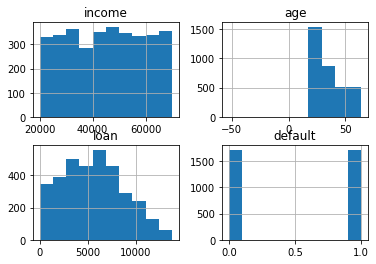

In [20]:
data.hist()

No outliers or anomalic data points can be seen in the histograms, so the data seems good!

In [21]:
data.dtypes

income     float64
age        float64
loan       float64
default      int64
dtype: object

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X = data.loc[:,["income","age","loan"]]
y = data.loc[:,["default"]]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [25]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Model Selection

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
import matplotlib.pyplot as plt

LR: 0.863435 (0.057667)
GBC: 0.990087 (0.009420)
CART: 0.987165 (0.006673)
RFC: 0.993878 (0.006578)


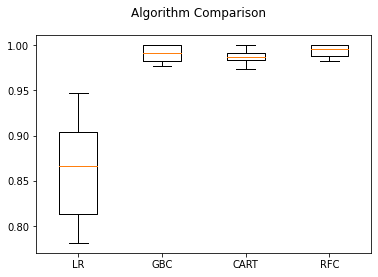

In [31]:
import warnings
warnings.filterwarnings('ignore')

seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

The random forest classifier is performing the best (based on accuracy), and so we will use it.

# Model Tuning

Below we will use RandomizedSearchCV to tune the model to find the gradients which produce the lowest loss. (GridSearchCV not used due to time constraints)

In [32]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
max_depth = range(2,20)
min_samples_leaf = range(1,5)
min_samples_split = range(1,5)
criterion= ["gini","entropy","log_loss"]

random_grid = {'max_depth': max_depth,
               'min_samples_leaf' : min_samples_leaf,
              'min_samples_split':min_samples_split,
              'criterion': criterion}

rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=50,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)
### fit the randomized model
rf_randomcv.fit(X_train,y_train)

rf_randomcv.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 16,
 'criterion': 'gini'}

Above are the tuned paramters we should use for the Random Forest.

In [35]:
from sklearn.metrics import classification_report

rf_final = RandomForestClassifier(max_depth=14,criterion='gini',min_samples_split=4,min_samples_leaf=1).fit(X_train,y_train)
preds = rf_final.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       355
           1       0.99      1.00      0.99       331

    accuracy                           0.99       686
   macro avg       0.99      0.99      0.99       686
weighted avg       0.99      0.99      0.99       686



In [37]:
import joblib
joblib.dump(rf_final,'random_forest')

['random_forest']

## Tuning Other Models

In [38]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
max_depth = range(2,20)
min_samples_leaf = range(1,5)
min_samples_split = range(1,5)

random_grid = {'max_depth': max_depth,
               'min_samples_leaf' : min_samples_leaf,
              'min_samples_split':min_samples_split}

gbc=GradientBoostingClassifier()
gbc_randomcv=RandomizedSearchCV(estimator=gbc,param_distributions=random_grid,n_iter=50,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)
### fit the randomized model
gbc_randomcv.fit(X_train,y_train)

gbc_randomcv.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 15}

In [39]:
from sklearn.metrics import classification_report

gbc_final = GradientBoostingClassifier(max_depth=15,min_samples_split=4,min_samples_leaf=4).fit(X_train,y_train)
preds = gbc_final.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       355
           1       0.99      0.98      0.99       331

    accuracy                           0.99       686
   macro avg       0.99      0.99      0.99       686
weighted avg       0.99      0.99      0.99       686



In [45]:
import joblib
joblib.dump(gbc_final,'gradient_boosting')

['gradient_boosting']

In [42]:
# Number of trees in random forest
penalty = ['l1','l2','elasticnet','none']
max_iter = [50,100,150,200]

random_grid = {'penalty': penalty,
               'max_iter' : max_iter}

lr=LogisticRegression()
lr_randomcv=RandomizedSearchCV(estimator=lr,param_distributions=random_grid,n_iter=50,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)
### fit the randomized model
lr_randomcv.fit(X_train,y_train)

lr_randomcv.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


{'penalty': 'none', 'max_iter': 50}

In [44]:
lr_final = LogisticRegression(penalty='none',max_iter=50).fit(X_train,y_train)
preds = lr_final.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       355
           1       0.92      0.97      0.94       331

    accuracy                           0.94       686
   macro avg       0.95      0.95      0.94       686
weighted avg       0.95      0.94      0.94       686



In [46]:
joblib.dump(lr_final,'linear_regression')

['linear_regression']

In [48]:
max_depth = range(2,20)
min_samples_leaf = range(1,5)
min_samples_split = range(1,5)
criterion= ["gini","entropy","log_loss"]

random_grid = {'max_depth': max_depth,
               'min_samples_leaf' : min_samples_leaf,
              'min_samples_split':min_samples_split,
              'criterion': criterion}

cart=DecisionTreeClassifier()
cart_randomcv=RandomizedSearchCV(estimator=cart,param_distributions=random_grid,n_iter=50,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)
### fit the randomized model
cart_randomcv.fit(X_train,y_train)

cart_randomcv.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_depth': 12,
 'criterion': 'entropy'}

In [49]:
from sklearn.metrics import classification_report

cart_final = DecisionTreeClassifier(max_depth=12,criterion='entropy',min_samples_split=4,min_samples_leaf=4).fit(X_train,y_train)
preds = cart_final.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       355
           1       0.99      0.98      0.98       331

    accuracy                           0.98       686
   macro avg       0.98      0.98      0.98       686
weighted avg       0.98      0.98      0.98       686



In [50]:
joblib.dump(cart_final,'cart_model')

['cart_model']